In [61]:
import os
from os import listdir
from os.path import isfile, join
import torchvision
import pandas as pd
import torch
from matplotlib import pyplot as plt
from IPython import display
from d2l import torch as d2l
from torch import nn
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision.transforms as Augment

In [62]:
"""Read num_sample pairs of jpg images and their labels to memory. Return two lists: the list of images
include images as torch.tensor in int type. The list of labels contains the correct digit expressed by the images
image and corresponding digit have the same index in their lists."""

def read_data(num_sample, is_train=True):
    data_dir = 'C:/Users/xuefeng/data/platelets/trainSet'
    transform = torchvision.transforms.Compose([torchvision.transforms.PILToTensor()])
    rotate = Augment.RandomRotation(180)
    images, labels = [], []
    if is_train:
        for label in range(2):
            for num_image in range(num_sample//2):
                mypath = os.path.join(data_dir, str(label))
                allfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
                img = Image.open(os.path.join(mypath, allfiles[num_image]))
                img = img.resize((28, 28))
                
                tensor = transform(img)
                img = tensor[0]
                img  = img[None,:]

                images.append(img)
                labels.append(label)
                    
    else:
        for label in range(2):
            for num_image in range(num_sample//2):
                mypath = os.path.join(data_dir, str(label))
                allfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
                img = Image.open(os.path.join(mypath, allfiles[-num_image-1]))
                img = img.resize((28, 28))

                tensor = transform(img)
                img = tensor[0]
                img  = img[None,:]
                images.append(img)
                labels.append(label)
    return images, labels

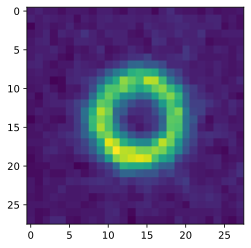

In [63]:
images, labels = read_data(8, is_train=True)
plt.imshow(images[6].permute(1, 2, 0))

In [64]:
"""Build a dataset that can be used by torch.utils.data.DataLoader"""
class PlateletDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, num_sample, is_train):
        self.features, self.labels = read_data(num_sample, is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float()/256, self.labels[idx])

    def __len__(self):
        return len(self.features)

In [65]:
"""Load the digit dataset."""
def load_data_platelet(num_sample, batch_size, is_train=True):
    train_iter = torch.utils.data.DataLoader(PlateletDataset(num_sample, is_train), batch_size, shuffle=True)
    return train_iter

In [66]:
num_sample = 160
batch_size = 40
train_iter = load_data_platelet(num_sample, batch_size, is_train=True)
val_iter = load_data_platelet(40, 20, is_train=False)

read 160 training examples
read 40 validation examples


In [18]:
"""Basic Softmax linear network"""
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 2))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [28]:
"""Basic Multiple perceptron network (MLP)"""
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Dropout(0.4),
                    nn.Linear(256, 2))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [76]:
"""Basic Convolutional neural network (CNN)"""
net = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=7, padding=3), 
    nn.Sigmoid(),
    nn.Flatten(),
    nn.Linear(784, 120),
    nn.Linear(120, 2))

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential(
  (0): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): Sigmoid()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=784, out_features=120, bias=True)
  (4): Linear(in_features=120, out_features=2, bias=True)
)

In [77]:
loss = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

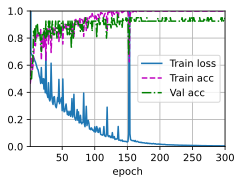

In [78]:
num_epochs = 300
d2l.train_ch3(net, train_iter, val_iter, loss, num_epochs, optimizer)

In [24]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i], fontsize=10)
    return axes

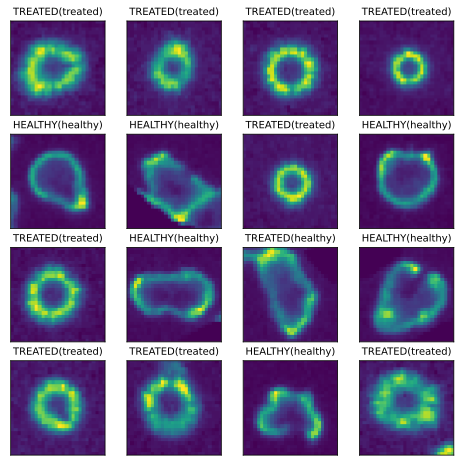

In [31]:
def recognize_platelet(net, val_iter, n=16):
    for X, y in val_iter:
        break
    health_condition = d2l.argmax(net(X), axis=1)
    
    titles = ["HEALTHY" if p.item() == 0 else "TREATED" for p in health_condition]
    for t in range(len(titles)):
        if y[t] == 0:
            titles[t] += "(healthy)"
        else:
            titles[t] += "(treated)"
    
    show_images(d2l.reshape(X[0:n], (n, 28, 28)), 4, 4, titles=titles[0:n])

recognize_platelet(net, val_iter, 16)